In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import copy
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
train_dir = './train'
test_dir = './val_and_test'
checkpoint_dir = './checkpoints'
result_path = './submission.csv'

In [10]:
# The "datasets" below open your images and preprocess them

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))


In [11]:
# The data loaders below collect your images and put them into batches to feed the neural network 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [12]:
# Define a simple CNN architecture
class Simple_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Simple_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=11, stride=4, padding=2),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(8, 8, kernel_size=3, padding=2),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #additional layer
#            nn.Conv2d(8, 8, kernel_size=3, padding=2),
#            nn.ReLU(inplace=True),
#            nn.LeakyReLU(negative_slope=0.01, inplace=True),
#            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
#             nn.Conv2d(16, 16, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(16, 16),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(16, 16),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01,inplace=True),
            nn.Linear(16, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
#        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [15]:
# Use cross-entropy loss
criterion = nn.CrossEntropyLoss()

In [16]:
def get_accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)

    _, pred = output.topk(1, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[0].view(-1).float().sum(0, keepdim=True)

    return correct_k.mul_(1.0 / batch_size).data[0]

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
def train(model, data_loader, criterion, optimizer, val_num):
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    
    model.train() # switch to train mode
    for i, (input, target) in enumerate(data_loader):
        if i != val_num:
            input, target = Variable(input), Variable(target)
            output = model(input)
            loss = criterion(output, target)

            optimizer.zero_grad() # clear the gradients computed before
            loss.backward() # compute the gradients using backward propagation
            optimizer.step() # update the parameters of the network

            accuracy = get_accuracy(output, target)
            loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
            print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
            loss_recorder.update(loss, input.size(0))
            accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [19]:
def validate(model, data_loader, criterion, val_num):
    
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    model.eval() # switch to evaluation mode
    for i, (input, target) in enumerate(data_loader):
        if i==val_num:
            input, target = Variable(input, volatile=True), Variable(target)
            output = model(input)
            loss = criterion(output, target)
            accuracy = get_accuracy(output, target)
            loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
            print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
            loss_recorder.update(loss, input.size(0))
            accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [20]:
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print('A checkpoint was saved to {}'.format(filename))

In [21]:
def pltLoss(train, val, num_epochs):
    plt.figure()
    plt.plot(np.arange(num_epochs)+1, train)
    plt.plot(np.arange(num_epochs)+1, val)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.pause(0.05)

In [22]:
def pltAcc(train, val, num_epochs):
    plt.figure()
    plt.plot(np.arange(num_epochs)+1, train)
    plt.plot(np.arange(num_epochs)+1, val)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])
    plt.pause(0.05)

In [23]:
def getResNetModel():
    model_conv=torchvision.models.resnet50(pretrained=True)
    ## Change the last layer
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)
    ## Freezing all layers
    for params in model_conv.parameters():
        params.requires_grad = False
    return model_conv


def getResNetModelFineTuning():
    model_conv=torchvision.models.resnet50(pretrained=True)
    ## Change the last layer
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)
    ## Freezing all layers
    for params in model_conv.parameters():
        params.requires_grad = False
    return model_conv

    ## Freezing the first few layers. Here I am freezing the first 7 layers 
    ct = 0
    for name, child in model_conv.named_children():
        ct += 1
        if ct < 7:
            for name2, params in child.named_parameters():
                params.requires_grad = False

def getVGGModel():
    
    model_conv = torchvision.models.vgg19(pretrained=True)

    # Number of filters in the bottleneck layer
    num_ftrs = model_conv.classifier[6].in_features
    # convert all the layers to list and remove the last one
    features = list(model_conv.classifier.children())[:-1]
    ## Add the last layer based on the num of classes in our dataset
    features.extend([nn.Linear(num_ftrs, 2)])
    ## convert it into container and add it to our model class.
    model_conv.classifier = nn.Sequential(*features)  

    return model_conv

In [24]:
def initModel(modelID):
    if modelID==1:
        model=Simple_CNN()
    elif modelID==2:
        model=getResNetModel()
    elif modelID==3:
        model=getResNetModelFineTuning()
    else:
        model=getVGGModel()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [29]:
def epochsModel(model, val, maxAcc, train_losses, train_accuracies, val_losses, val_accuracies, mdlID):
    print('---- train ----')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, val)
    print('Avg Loss: {:.05f}\tAvg Accuracy: {:.05f}'.format(train_loss, train_accuracy))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print('-- validate --')
    val_loss, val_accuracy = validate(model, train_loader, criterion, val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    save_checkpoint(model.state_dict(), checkpoint_dir+'/checkpoint{}_epoch{}.pk'.format(mdlID,epoch))
    if val_accuracy > maxAcc:
        bstMdl=copy.deepcopy(model.state_dict())
        maxAcc=val_accuracy
        valNum=val
    elif val_accuracy == maxAcc:
        n=random.randrange(1,2)
        if n==2:
            bstMdl=copy.deepcopy(model.state_dict())
            maxAcc=val_accuracy
            valNum=val
    return model, train_losses, train_accuracies, val_losses, val_accuracies, bstMdl

Validation 1

Epoch 1
---- train ----
Batch 2:	loss: 0.68848	 accuracy: 0.55000
Batch 3:	loss: 0.69256	 accuracy: 0.52500
Batch 4:	loss: 0.70459	 accuracy: 0.45000
Batch 5:	loss: 0.68828	 accuracy: 0.55000
Avg Loss: 0.69348	Avg Accuracy: 0.51875
-- validate --
Batch 1:	loss: 0.69236	 accuracy: 0.52500
A checkpoint was saved to ./checkpoints/checkpoint1_epoch1.pk

Epoch 2
---- train ----
Batch 2:	loss: 0.69232	 accuracy: 0.52500
Batch 3:	loss: 0.67663	 accuracy: 0.62500
Batch 4:	loss: 0.70771	 accuracy: 0.42500
Batch 5:	loss: 0.69594	 accuracy: 0.50000
Avg Loss: 0.69315	Avg Accuracy: 0.51875
-- validate --
Batch 1:	loss: 0.68386	 accuracy: 0.57500
A checkpoint was saved to ./checkpoints/checkpoint1_epoch2.pk


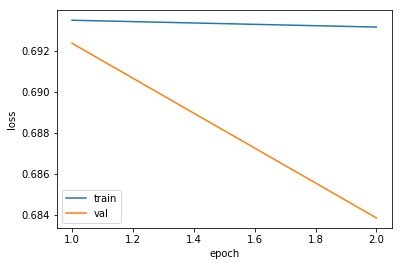

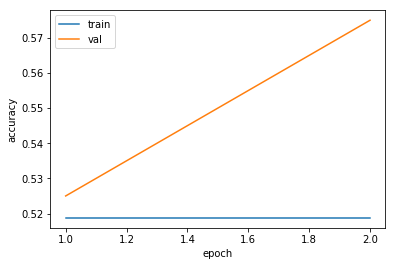

Validation 2

Epoch 1
---- train ----
Batch 1:	loss: 0.67997	 accuracy: 0.60000
Batch 3:	loss: 0.68315	 accuracy: 0.57500
Batch 4:	loss: 0.70873	 accuracy: 0.42500
Batch 5:	loss: 0.67986	 accuracy: 0.60000
Avg Loss: 0.68793	Avg Accuracy: 0.55000
-- validate --
Batch 2:	loss: 0.68858	 accuracy: 0.55000
A checkpoint was saved to ./checkpoints/checkpoint1_epoch1.pk

Epoch 2
---- train ----
Batch 1:	loss: 0.68657	 accuracy: 0.55000
Batch 3:	loss: 0.71497	 accuracy: 0.40000
Batch 4:	loss: 0.66764	 accuracy: 0.65000
Batch 5:	loss: 0.69905	 accuracy: 0.47500
Avg Loss: 0.69206	Avg Accuracy: 0.51875
-- validate --
Batch 2:	loss: 0.70656	 accuracy: 0.42500
A checkpoint was saved to ./checkpoints/checkpoint1_epoch2.pk


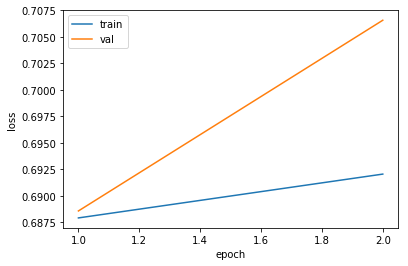

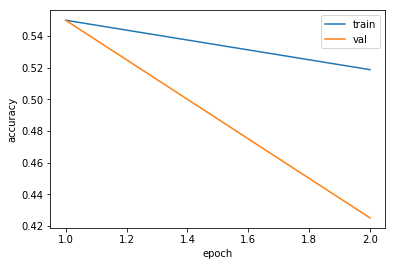

Validation 3

Epoch 1
---- train ----
Batch 1:	loss: 0.69651	 accuracy: 0.32500
Batch 2:	loss: 0.69314	 accuracy: 0.50000
Batch 4:	loss: 0.69205	 accuracy: 0.65000
Batch 5:	loss: 0.69244	 accuracy: 0.65000
Avg Loss: 0.69354	Avg Accuracy: 0.53125
-- validate --
Batch 3:	loss: 0.69248	 accuracy: 0.57500
A checkpoint was saved to ./checkpoints/checkpoint1_epoch1.pk

Epoch 2
---- train ----
Batch 1:	loss: 0.69292	 accuracy: 0.62500
Batch 2:	loss: 0.69248	 accuracy: 0.62500
Batch 4:	loss: 0.69122	 accuracy: 0.75000
Batch 5:	loss: 0.69214	 accuracy: 0.55000
Avg Loss: 0.69219	Avg Accuracy: 0.63750
-- validate --
Batch 3:	loss: 0.69178	 accuracy: 0.65000
A checkpoint was saved to ./checkpoints/checkpoint1_epoch2.pk


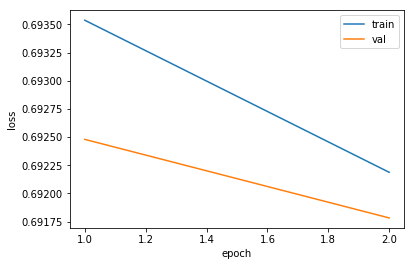

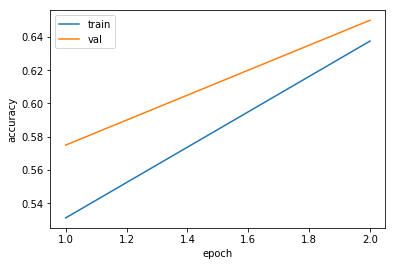

Validation 4

Epoch 1
---- train ----
Batch 1:	loss: 0.70305	 accuracy: 0.40000
Batch 2:	loss: 0.68685	 accuracy: 0.57500
Batch 3:	loss: 0.69381	 accuracy: 0.50000
Batch 5:	loss: 0.69790	 accuracy: 0.42500
Avg Loss: 0.69540	Avg Accuracy: 0.47500
-- validate --
Batch 4:	loss: 0.68685	 accuracy: 0.57500
A checkpoint was saved to ./checkpoints/checkpoint1_epoch1.pk

Epoch 2
---- train ----


In [ ]:
num_epochs=2
valNum=5
bestModels=[]
for mdl in range(1,4):
    for val in range(0,valNum):
        model, trn_loss, trn_acc, val_loss, val_acc=initModel(mdl)
        # Create a ADAM optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        maxAcc=0.0
        print('Validation {}'.format(val+1))
        for epoch in range(1, num_epochs+1):
            print('\nEpoch', epoch)
            model,trn_loss,trn_acc,val_loss,val_acc,bstMdl=epochsModel(model,val,maxAcc,trn_loss,trn_acc,val_loss,val_acc,mdl)
        pltLoss(trn_loss, val_loss, num_epochs)
        pltAcc(trn_acc, val_acc, num_epochs)
        bestModels.append(bstMdl)

In [24]:
print(train_accuracy)

0.48125000298023224


Choose a model that you like best

In [170]:
prefered_checkpoint = 'C:/Users/showe/Documents/masters/SP18/CS8750/Project/code/data/checkpoints/checkpoint_epoch50.pk'
model.load_state_dict(torch.load(prefered_checkpoint))

Let your AI automatically recognize if there are birds in each images in test set

In [171]:
images = []
preds = []
model.eval()
for i, (input, target) in enumerate(tqdm(test_loader)):
    input, target = Variable(input, volatile=True), Variable(target)
    output = bstmdl(input)
    confidence = nn.functional.softmax(output, dim=1)
    confidence = confidence.cpu().data[0].numpy()
    if confidence[0] >= 0.5: # If the network predicts that the image contains a bird
        pred = 1
    else:
        pred = 0
    preds.append(pred)
    
    # Get the file name of the current image
    image = test_dataset.imgs[i]
    image = os.path.basename(image[0])
    images.append(image)
submission = pd.DataFrame({'image': images, 'has_bird': preds}, columns=['image', 'has_bird'])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.16it/s]


Take a look at the first rows of the result.

In [172]:
submission.head()

,image,has_bird
0,0000.JPG,1
1,0001.JPG,0
2,0002.JPG,1
3,0003.JPG,0
4,0004.JPG,0


In [173]:
submission.to_csv(result_path, index=False)